# Using Traditional Aproach

In [1]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r'— oem 3 — psm 6' 
from matplotlib import pyplot as plt


pytesseract.pytesseract.tesseract_cmd = r'D:\Work Station\Tesseract\tesseract.exe'

In [4]:
base_dir = "./Data/"

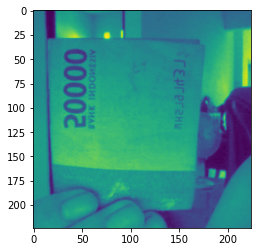

In [132]:
# load raw image
img = cv2.imread(base_dir+"50K-samples/0.jpg",0)

# display raw image
plt.imshow(img)
plt.show()

In [133]:
# Sharpen the Image

def sharpen_image(im):
  kernel = np.ones((3,3),np.float32)/90
  im = cv2.filter2D(im,-1,kernel)
  return im

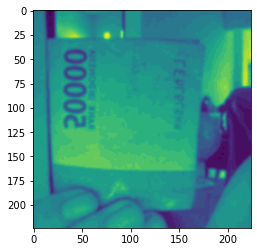

In [134]:
img = sharpen_image(img)
# display sharpened image
plt.imshow(img)
plt.show()

seem better without sharpen :3

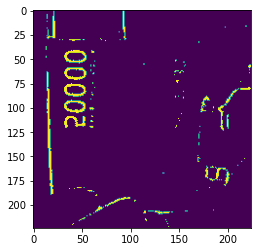

In [135]:
# apply image thresholding
img_thresh = cv2.adaptiveThreshold(img,    
          255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# invert the image, 255 is the maximum value
img_thresh = 255 - img_thresh
# display image
plt.imshow(img_thresh)
plt.show()

88.8426742553711


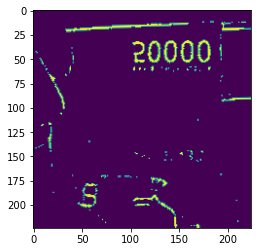

In [136]:
def align_text(im):
  coords = np.column_stack(np.where(img_thresh > 0))
  angle = cv2.minAreaRect(coords)[-1]
  print(angle)
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  h,w = img.shape
  center = (w // 2, h // 2)
  
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(img_thresh, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated
# align image text
img = align_text(img)
# display rotated and aligned image
plt.imshow(img)
plt.show()

In [137]:
# split text into rows
# find sum of column values, row-wise
a = np.sum(img == 255, axis=1)
rows = []
seg = []
for i in range(len(a)):
  if a[i] > 0:
    seg.append(i)
  if (a[i] == 0) & (len(seg) >= 5):
    rows.append(seg)
    seg = []
  if len(seg) > 0:
    rows.append(seg)
# number of row segments
len(rows)

184

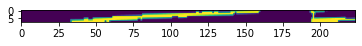

In [138]:
plt.imshow(img[rows[0][0]:rows[0][-1],:])
plt.show()

In [139]:
for i in range(len(rows)):
  a = pytesseract.image_to_string(img[rows[i][0]:rows[i][-1],:],config=custom_config,lang='ind')
  if len(a) > 0:
    print(a) 

## Summary
- Traditional Aproach seems doesnt really good :'

# Using Deep Learning Aproach

In [46]:
'''Restart Kernel to proceed'''

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# %matplotlib inline

In [2]:
base_dir = "Data"

In [3]:
import splitfolders

splitfolders.ratio(base_dir,output="output",seed=1337,ratio=(.7,.2,.1))

In [4]:
import os
new_dir = 'output'
train_dir = os.path.join(new_dir,'train')
val_dir = os.path.join(new_dir,'val')
test_dir = os.path.join(new_dir,'test')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')
 
test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [11]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),
        batch_size=16,
        color_mode= 'rgb',
        class_mode='categorical')
 
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150), 
        batch_size=16,
        color_mode= 'rgb',
        class_mode='categorical')

Found 320 images belonging to 3 classes.
Found 91 images belonging to 3 classes.


In [33]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [34]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [35]:
fitted_model = model.fit(
      train_generator,
      epochs=25, # tambahkan eposchs jika akurasi model belum optimal
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2)

Epoch 1/25
20/20 - 10s - loss: 1.2382 - accuracy: 0.6125 - val_loss: 0.5275 - val_accuracy: 0.6750
Epoch 2/25
20/20 - 9s - loss: 0.4188 - accuracy: 0.8188 - val_loss: 0.1705 - val_accuracy: 0.9375
Epoch 3/25
20/20 - 9s - loss: 0.1558 - accuracy: 0.9375 - val_loss: 0.0983 - val_accuracy: 0.9750
Epoch 4/25
20/20 - 11s - loss: 0.0670 - accuracy: 0.9844 - val_loss: 0.1820 - val_accuracy: 0.9125
Epoch 5/25
20/20 - 11s - loss: 0.0937 - accuracy: 0.9656 - val_loss: 0.1033 - val_accuracy: 0.9750
Epoch 6/25
20/20 - 11s - loss: 0.0666 - accuracy: 0.9656 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 7/25
20/20 - 11s - loss: 0.0677 - accuracy: 0.9656 - val_loss: 0.1009 - val_accuracy: 0.9875
Epoch 8/25
20/20 - 11s - loss: 0.0255 - accuracy: 0.9969 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 9/25
20/20 - 11s - loss: 0.0390 - accuracy: 0.9906 - val_loss: 0.0134 - val_accuracy: 0.9875
Epoch 10/25
20/20 - 11s - loss: 0.0230 - accuracy: 0.9937 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 11/25

In [36]:
val_dir = "output/val"

In [43]:
test_images = ["/50K-samples/1.jpg","/50K-samples/6.jpg","/50K-samples/11.jpg",
               "/10K-samples/4.jpg","/10K-samples/10.jpg","/10K-samples/11.jpg",
               "/100K-samples/2.jpg","/100K-samples/80.jpg","/100K-samples/100.jpg",
               ]

[[0. 0. 1.]]
50k
[[0. 0. 1.]]
50k
[[0. 0. 1.]]
50k
[[0. 1. 0.]]
10k
[[0. 1. 0.]]
10k
[[0. 1. 0.]]
10k
[[1. 0. 0.]]
100k
[[1. 0. 0.]]
100k
[[1. 0. 0.]]
100k


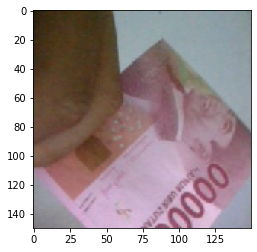

In [47]:

for image_path in test_images:
    path = val_dir+image_path
    img = image.load_img(path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)

    # print(fn)
    print(classes)
    if classes[0][0]==1:
        print('100k')
    elif classes[0][1]==1:
        print('10k')
    elif classes[0][2]==1:
        print('50k')

In [52]:
import joblib
import pickle

In [54]:
model.save("1JuneClassification")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: 1JuneClassification\assets
